In [1]:
from tensorflow.keras import layers, Model
from tensorflow.keras import regularizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, BatchNormalization
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler
import keras
import sys
import pandas as pd
import sklearn as sk
import numpy as np

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU')) > 0
print(tf.config.list_physical_devices('GPU'))
print("GPU is", "available" if gpu else "NOT AVAILABLE")

2025-07-27 08:42:42.850951: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-27 08:42:42.978578: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-27 08:42:43.004015: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-27 08:42:43.678764: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

Tensor Flow Version: 2.10.1
Keras Version: 2.10.0

Python 3.8.12 (default, Mar 27 2025, 14:46:10) 
[GCC 7.5.0]
Pandas 1.2.5
Scikit-Learn 1.3.2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU is available


2025-07-27 08:42:45.449163: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-27 08:42:45.469173: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-27 08:42:45.470437: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     # Asignar 8GB a cada modelo (24GB total / 3 modelos)
#     tf.config.set_logical_device_configuration(
#         gpus[0],
#         [tf.config.LogicalDeviceConfiguration(memory_limit=10000)]  # 8GB en MB
#     )
#     print("GPU limitada a 10GB para este notebook.")

In [3]:
# SEMILLA
tf.random.set_seed(42)

In [4]:
# Parámetros
forma_entrada = (224, 224, 3)
tamaño_lote = 64
épocas = 60
initial_learning_rate = 1e-3

preprocess_fn = tf.keras.applications.vgg16.preprocess_input


# Rutas
ruta_entrenamiento = './datasets/2D/data_augmentation/color_2/train'
ruta_validacion = './datasets/2D/data_augmentation/color_2/validation'
ruta_test = './datasets/2D/data_augmentation/color_2/test'

# ruta_entrenamiento = './datasets/order_data/color/train'
# ruta_validacion = './datasets/order_data/color/validation'
# ruta_test = './datasets/order_data/color/test'

# Generadores
datagen = ImageDataGenerator(
    # preprocessing_function=preprocess_fn,
    rescale=1./255
)
datagen_valid = ImageDataGenerator(
    # preprocessing_function=preprocess_fn,
    rescale=1./255
) # ANTES APLIQUE RESCALE
datagen_test = ImageDataGenerator(
    # preprocessing_function=preprocess_fn,
    rescale=1./255
)

generador_entrenamiento = datagen.flow_from_directory(
    ruta_entrenamiento,
    target_size=forma_entrada[:2],
    batch_size=tamaño_lote,
    shuffle=True,
    class_mode='categorical'
)

generador_validacion = datagen_valid.flow_from_directory(
    ruta_validacion,
    target_size=forma_entrada[:2],
    batch_size=tamaño_lote,
    shuffle=False,
    class_mode='categorical'
)

generador_test = datagen_test.flow_from_directory(
    ruta_test,
    target_size=forma_entrada[:2],
    batch_size=tamaño_lote,
    shuffle=False,
    class_mode='categorical'
)


Found 40000 images belonging to 4 classes.
Found 5000 images belonging to 4 classes.
Found 5000 images belonging to 4 classes.


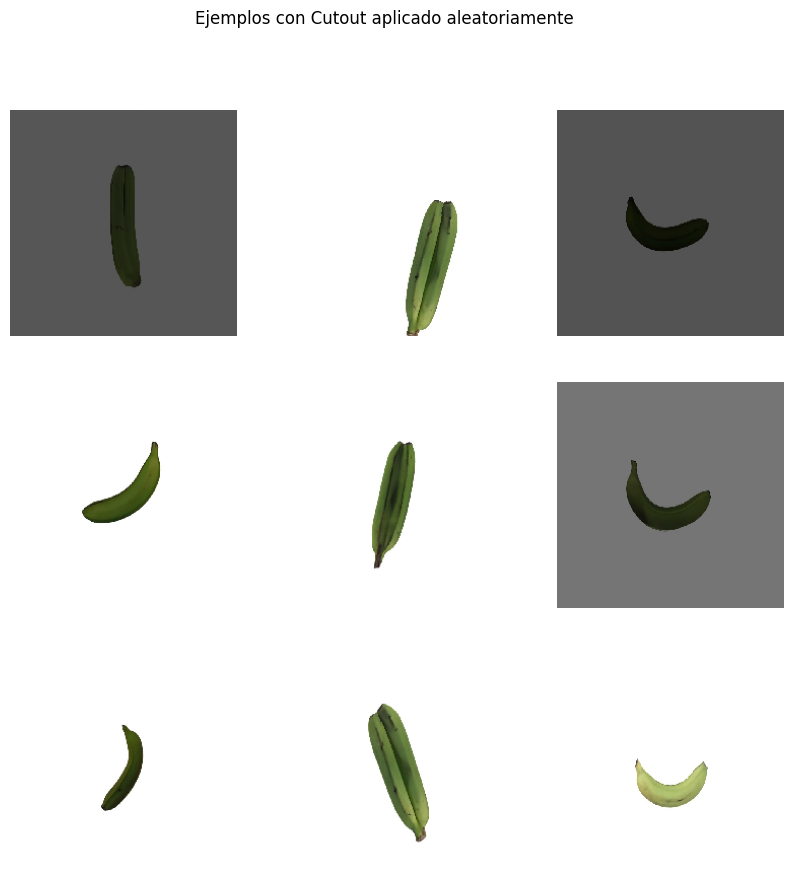

In [5]:
X, _ = next(generador_entrenamiento)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)  # Nota: i+1 para que los índices empiecen en 1
    plt.imshow(X[i])  # Añade cmap='gray' para imágenes en escala de grises
    plt.axis('off')
plt.suptitle('Ejemplos con Cutout aplicado aleatoriamente')
plt.show()

In [6]:
steps = len(generador_entrenamiento.filepaths) // generador_entrenamiento.batch_size
steps

625

In [7]:
##### AÑADIR LR DECAY FACTOR #####
# learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=initial_learning_rate,
#     decay_steps=30*steps,  # Decaimiento más frecuente
#     decay_rate=0.9,  # Decaimiento más fuerte
#     staircase=True)
learning_rate = initial_learning_rate

In [8]:
# !pip install tensorflow-addons

In [9]:
# latest = "models/VGG16/siamese_model_vgg16_apple_data_REF.h5"

# base_model = tf.keras.models.load_model(latest, compile=False)

# base_model.summary()

In [10]:
# # Extraer solo la parte VGG16 del modelo cargado
# vgg_layer = base_model.get_layer('vgg16')  # Asumiendo que se llama 'vgg16' en tu modelo cargado
# vgg_layer.trainable = False  # Congelar pesos

# entrada = layers.Input(shape=forma_entrada)
# x = vgg_layer(entrada)  # Usar la VGG16 cargada
# x = layers.Flatten()(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
# x = layers.Dropout(0.75)(x)
# salida = layers.Dense(4, activation='softmax')(x)

# # 3. Compilar
# model = Model(inputs=entrada, outputs=salida)
# optimizador = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# model.compile(
#     loss='categorical_crossentropy', 
#     optimizer=optimizador, 
#     metrics=['accuracy']
# )
# #
# model.summary()

In [11]:
# Construccion del modelo
# --------------------------------------------------------------------------
def model_init(learning_rate, dropout_rate, l2_reg):
    base_model = VGG16(
        weights='imagenet', 
        include_top=False, 
        input_shape=forma_entrada
    )
    
    for layer in base_model.layers:
        layer.trainable = False
        
    entrada = layers.Input(shape=forma_entrada)
    x = base_model(entrada)
    x = layers.Flatten()(x)
    # x = BatchNormalization()(x)
    x = layers.Dense(
        256,
        activation='relu',
        kernel_regularizer=regularizers.l2(l2_reg)
    )(x)
    x = layers.Dropout(dropout_rate)(x)
    salida = layers.Dense(4, activation='softmax')(x)
    
    model = Model(inputs=entrada, outputs=salida)
    optimizador = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        loss='categorical_crossentropy', 
        optimizer=optimizador, 
        metrics=['accuracy']
    )
    return model

from bayes_opt import BayesianOptimization
from sklearn.model_selection import train_test_split
import numpy as np

# 1. Definir función objetivo a optimizar
def optimize_model(lr, dropout_rate, l2_reg, batch_size):
    # Convertir parámetros
    lr = 10**lr  # Usar escala logarítmica
    l2_reg = 10**l2_reg
    batch_size = int(batch_size)
    
    # Construir modelo con hiperparámetros actuales
    modelo = model_init(
        learning_rate=lr,
        dropout_rate=dropout_rate,
        l2_reg=l2_reg
    )
    
    # Entrenamiento reducido para evaluación rápida
    history = modelo.fit(
        generador_entrenamiento_combinado,
        #steps_per_epoch=train_samples // tamaño_lote,  # Subconjunto para optimización
        validation_data=generador_validacion_combinado,
        #validation_steps=val_samples // tamaño_lote,
        epochs=3,
        verbose=1
    )
    
    # Retornar el mejor valor de val_accuracy
    return np.max(history.history['val_accuracy'])

# 2. Definir espacio de búsqueda
pbounds = {
    'lr': (-5, -3),       # 10^-5 a 10^-3
    'dropout_rate': (0.3, 0.7),
    'l2_reg': (-5, -2),   # 10^-5 a 10^-2
    'batch_size': (16, 64) # Discretizar después
}

# 3. Crear optimizador bayesiano
optimizer = BayesianOptimization(
    f=optimize_model,
    pbounds=pbounds,
    random_state=42,
    verbose=1
)

# 4. Ejecutar optimización
optimizer.maximize(
    init_points=10,  # Exploración inicial aleatoria
    n_iter=2,      # Iteraciones bayesianas
)

# Obtener mejores parámetros
best_params = optimizer.max['params']
best_params['batch_size'] = int(best_params['batch_size'])  # Discretizar

# Construir modelo final con mejores parámetros
model = model_init(
    learning_rate=10**best_params['lr'],
    dropout_rate=best_params['dropout_rate'],
    l2_reg=10**best_params['l2_reg']
)

In [12]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import train_test_split
import numpy as np

# 1. Definir función objetivo a optimizar
def optimize_model(lr, dropout_rate, l2_reg):
    # Convertir parámetros
    lr = 10**lr  # Usar escala logarítmica
    l2_reg = 10**l2_reg

    # Construir modelo con hiperparámetros actuales
    modelo = model_init(
        learning_rate=lr,
        dropout_rate=dropout_rate,
        l2_reg=l2_reg
    )
    
    # Entrenamiento reducido para evaluación rápida
    history = modelo.fit(
        generador_entrenamiento,
        # steps_per_epoch=train_samples // tamaño_lote,  # Subconjunto para optimización
        validation_data=generador_validacion,
        # validation_steps=val_samples // tamaño_lote,
        epochs=3,
        verbose=1
    )
    
    # Retornar el mejor valor de val_accuracy
    return np.max(history.history['val_accuracy'])

# 2. Definir espacio de búsqueda
pbounds = {
    'lr': (-5, -2),       # 10^-5 a 10^-3
    'dropout_rate': (0.7, 0.9),
    'l2_reg': (-5, -2),   # 10^-5 a 10^-2
}

# 3. Crear optimizador bayesiano
optimizer = BayesianOptimization(
    f=optimize_model,
    pbounds=pbounds,
    random_state=42,
    verbose=1
)

# 4. Ejecutar optimización
optimizer.maximize(
    init_points=2,  # Exploración inicial aleatoria
    n_iter=10,      # Iteraciones bayesianas
)

|   iter    |  target   | dropou... |  l2_reg   |    lr     |
-------------------------------------------------------------


2025-07-27 08:42:52.037961: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-27 08:42:52.040634: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-27 08:42:52.041308: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-27 08:42:52.042105: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may h

Epoch 1/3


2025-07-27 08:43:01.956725: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2025-07-27 08:43:03.671156: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2025-07-27 08:43:03.671261: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2025-07-27 08:43:03.671394: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


  2/625 [..............................] - ETA: 59s - loss: 6.3836 - accuracy: 0.4062    

2025-07-27 08:43:06.520187: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


625/625 [==============================] - 586s 927ms/step - loss: 3.3063 - accuracy: 0.8136 - val_loss: 1.4455 - val_accuracy: 0.9004
Epoch 2/3
625/625 [==============================] - 570s 912ms/step - loss: 1.4783 - accuracy: 0.8301 - val_loss: 1.0939 - val_accuracy: 0.8942
Epoch 3/3
625/625 [==============================] - 563s 901ms/step - loss: 1.2552 - accuracy: 0.8379 - val_loss: 1.1492 - val_accuracy: 0.8902
Epoch 1/3
625/625 [==============================] - 569s 909ms/step - loss: 0.5103 - accuracy: 0.8150 - val_loss: 0.2355 - val_accuracy: 0.9302
Epoch 2/3
625/625 [==============================] - 560s 896ms/step - loss: 0.2346 - accuracy: 0.9174 - val_loss: 0.1847 - val_accuracy: 0.9456
Epoch 3/3
625/625 [==============================] - 565s 903ms/step - loss: 0.1723 - accuracy: 0.9398 - val_loss: 0.1648 - val_accuracy: 0.9542
| 2         | 0.9542    | 0.8197    | -4.532    | -4.532    |
Epoch 1/3
625/625 [==============================] - 581s 928ms/step - loss: 0

In [13]:
optimizer.max['params']

{'dropout_rate': 0.75926516037996,
 'l2_reg': -4.56959162894594,
 'lr': -4.545663434193928}

In [14]:
# Obtener mejores parámetros
best_params = optimizer.max['params']

# Construir modelo final con mejores parámetros
model = model_init(
    learning_rate=10**best_params['lr'],
    dropout_rate=best_params['dropout_rate'],
    l2_reg=10**best_params['l2_reg']
)

In [15]:
#model = model_init(learning_rate, 0.7, 1e-4)

In [16]:
# Configuración de callbacks
import os
path_models = './models/pruebas/VGG16_RGB_bayesian_batchdef/'
os.makedirs(path_models, exist_ok=True)
arch = 'VGG16_SINGLE_INPUT'

In [17]:
# Ruta donde se guardará el archivo (ej: 'C:/Users/tu_usuario/proyecto/resultados/hiperparametros.txt')
ruta_archivo = path_models + "hiperparametros.txt"  # ¡Cambia esto!

# Asegurarse de que la carpeta exista (si no, la crea)
os.makedirs(os.path.dirname(ruta_archivo), exist_ok=True)

# Guardar en formato legible (clave = valor)
with open(ruta_archivo, "w") as f:
    for key, value in best_params.items():
        f.write(f"{key} = {value}\n")

print(f"¡Hiperparámetros guardados en: {ruta_archivo}!")

¡Hiperparámetros guardados en: ./models/pruebas/VGG16_RGB_bayesian_batchdef/hiperparametros.txt!


In [18]:
checkpoint = ModelCheckpoint(
    path_models + "model_single_input_silhouette_0_0.h5",
    monitor='val_loss', # <-- Guarda el mejor modelo basado en val_loss (más estable que val_accuracy)
    verbose=1,
    save_best_only=True, # guarda cuando haya mejoras
    save_weights_only=True,
    mode='min', #estaba en auto
    period=10  # Guarda pesos cada 10 épocas
)

early = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001, 
    patience=10,  # <-- Detén el entrenamiento cuando val_accuracy no mejore en 10 épocas
    verbose=1,
    restore_best_weights=True,
    mode='max'
)
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitorear pérdida de validación
    mode='min',         # Reducir LR cuando val_loss deje de disminuir
    factor=0.5,         # Reducción moderada del LR
    patience=5,        # Esperar 5 épocas sin mejora
    verbose=1,
    min_lr=1e-6         # LR mínimo permitido+
)

# from tensorflow.keras.callbacks import ReduceLROnPlateau

# lr_scheduler = ReduceLROnPlateau(
#     monitor='val_accuracy',
#     factor=0.5,  # Reducir LR a la mitad
#     patience=10,  # Esperar 10 épocas sin mejora
#     min_lr=1e-6,  # LR mínimo
#     verbose=1
# )

# Añadir a los callbacks
callbacks = [checkpoint, reduce_lr, early]  # <-- Añadido

In [19]:
# Para TensorFlow 2.6 (compatible con CUDA 11.2 y cuDNN 8.1)
# %pip uninstall tensorflow -y
# %pip install tensorflow-gpu==2.6.0

In [20]:
historia = model.fit(
    generador_entrenamiento,
    #steps_per_epoch=generador_entrenamiento.samples // tamaño_lote,
    epochs=épocas,
    validation_data=generador_validacion,
    #validation_steps=generador_validacion.samples // tamaño_lote,
    callbacks=callbacks,
    # class_weight=class_weights  # <-- Añadir esto
)

model.save(path_models + arch + '/model_single_input_silhouette_0_0.h5')

Epoch 1/60
625/625 [==============================] - 624s 998ms/step - loss: 0.4080 - accuracy: 0.8456 - val_loss: 0.2130 - val_accuracy: 0.9378 - lr: 2.8467e-05
Epoch 2/60
625/625 [==============================] - 579s 925ms/step - loss: 0.1831 - accuracy: 0.9360 - val_loss: 0.1619 - val_accuracy: 0.9482 - lr: 2.8467e-05
Epoch 3/60
625/625 [==============================] - 572s 916ms/step - loss: 0.1290 - accuracy: 0.9589 - val_loss: 0.1500 - val_accuracy: 0.9524 - lr: 2.8467e-05
Epoch 4/60
625/625 [==============================] - 563s 901ms/step - loss: 0.1025 - accuracy: 0.9686 - val_loss: 0.1446 - val_accuracy: 0.9568 - lr: 2.8467e-05
Epoch 5/60
625/625 [==============================] - 562s 899ms/step - loss: 0.0851 - accuracy: 0.9742 - val_loss: 0.1558 - val_accuracy: 0.9518 - lr: 2.8467e-05
Epoch 6/60
625/625 [==============================] - 573s 916ms/step - loss: 0.0725 - accuracy: 0.9780 - val_loss: 0.1396 - val_accuracy: 0.9576 - lr: 2.8467e-05
Epoch 7/60
625/625 [==

Learning rate actual: 3.5583329223273554e-06


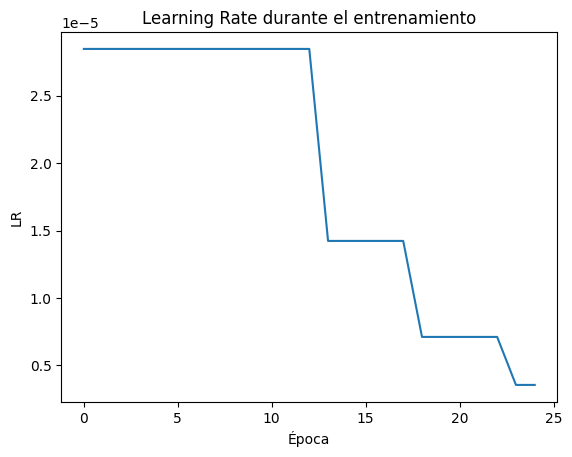

In [21]:
current_lr = model.optimizer.lr.numpy()
print(f"Learning rate actual: {current_lr}")

# Graficar el learning rate a lo largo de las épocas
plt.plot(historia.history['lr'])
plt.title('Learning Rate durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('LR')
plt.savefig(path_models +"VGG16_silhouette_0_0_lr_plot.png")
plt.show()

In [22]:
model.save(path_models + arch + '/model_single_input_silhouette_0_0.h5')

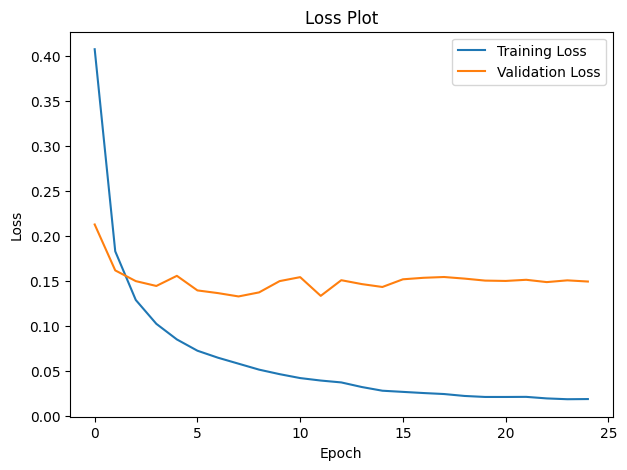

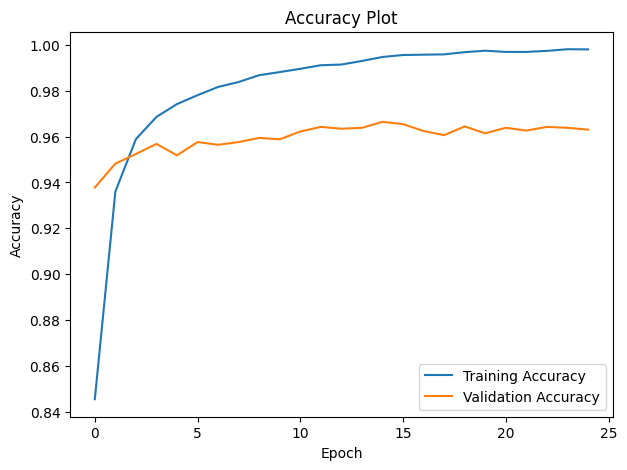

In [23]:
# Gráfico de Pérdida
plt.figure(figsize=(7,5))
plt.plot(historia.history['loss'], label='Training Loss')
plt.plot(historia.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss Plot")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig(path_models +"VGG16_silhouette_0_0_loss_plot.png")  # Guarda el gráfico en loss_plot.png
plt.show()

# Gráfico de Precisión
plt.figure(figsize=(7,5))
plt.plot(historia.history['accuracy'], label='Training Accuracy')
plt.plot(historia.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy Plot")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.savefig(path_models +"VGG16_silhouette_0_0_accuracy_plot.png")  # Guarda el gráfico en accuracy_plot.png
plt.show()

In [24]:
# # # #### USAR PESOS YA GUARDADOS
# from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# latest = path_models + arch + '/model_single_input_silhouette_0_0.h5'
# modelo = tf.keras.models.load_model(latest)
# modelo.summary()

# # Evaluación sobre el set de prueba
# y_pred = modelo.predict(generador_test, verbose=1)
# predicted_labels = np.argmax(y_pred, axis=1)
# true_labels = generador_test.classes


# categorias = ['Class 1', 'Class 2', 'Class 3', 'Class 4']

# #class_names = ["clase_1", "clase_2", "clase_3", "clase_4"]
# # class_names = ["clase_1", "clase_2"]
# # Calcular métricas
# print('Accuracy:', accuracy_score(true_labels, y_pred))

# from sklearn.metrics import classification_report

# # Suponiendo que tienes:
# # verdaderas: etiquetas verdaderas
# # predichas: etiquetas predichas
# # categorias: nombres de las clases

# # Generar el reporte
# reporte = classification_report(true_labels, y_pred, target_names=categorias)
# print(reporte)
# # Guardar en un archivo .txt
# with open(path_models+'reporte_clasificacion.txt', 'w') as archivo:
#     archivo.write(reporte)

In [25]:
#####Check Current Learning Rate######

#current_lr = learning_rate(model.optimizer.iterations)
#print(f"Current learning rate: {current_lr.numpy()}")

In [26]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Evaluación sobre el set de prueba
y_pred = model.predict(generador_test, verbose=1)
predicted_labels = np.argmax(y_pred, axis=1)
true_labels = generador_test.classes

# Calcular métricas
cm = confusion_matrix(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average=None)
recall = recall_score(true_labels, predicted_labels, average=None)
f1 = f1_score(true_labels, predicted_labels, average=None)

categories = ['Class 1', 'Class 2', 'Class 3', 'Class 4']

# Crear la gráfica de la matriz de confusión
sns.set(font_scale=1.4)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Pastel1_r', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predictions')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig(path_models + "VGG16_silhouette_0_0_confusion_matrix.png")  # Guarda la imagen en un archivo PNG
plt.close()  # Cierra la figura

class_counts = cm.sum(axis=1)  # número total de instancias reales por clase
diag = np.diag(cm)             # verdaderos positivos por clase
class_accuracy = diag / class_counts

# Tabla en pandas
df = pd.DataFrame({
    'Clase': categories,
    'Accuracy': class_accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})

# Imprimir en pantalla (opcional)
print(f"Accuracy: {accuracy}")
print(df)
print("Average Precision:", df["Precision"].mean())
print("Average Recall:", df["Recall"].mean())
print("Average F1-Score:", df["F1-Score"].mean())

# Guardar las métricas en un archivo de texto
with open(path_models + "VGG16_silhouette_0_0_metrics.txt", "w") as f:
    f.write(f"Accuracy: {accuracy}\n\n")
    f.write("Confusion Matrix:\n")
    f.write(np.array2string(cm))
    f.write("\n\nMetrics Table:\n")
    f.write(df.to_string(index=False))
    f.write("\n\n")
    f.write(f"Average Precision: {df['Precision'].mean()}\n")
    f.write(f"Average Recall: {df['Recall'].mean()}\n")
    f.write(f"Average F1-Score: {df['F1-Score'].mean()}\n")


79/79 [==============================] - 71s 897ms/step
Accuracy: 0.8586
     Clase  Accuracy  Precision  Recall  F1-Score
0  Class 1    0.9360   0.951220  0.9360  0.943548
1  Class 2    0.6504   0.770616  0.6504  0.705423
2  Class 3    0.8560   0.725424  0.8560  0.785321
3  Class 4    0.9920   1.000000  0.9920  0.995984
Average Precision: 0.8618148386881893
Average Recall: 0.8586
Average F1-Score: 0.8575691043123963
